The below code takes a load of information from MongoDB on the local server (that this Jupyter Notebook is running off) and visually analyses some of it - to look for correlations.

The first step is to import the required dependencies:

In [1]:
import pandas as pd
import pymongo
from pymongo import MongoClient
import pprint
import json  
import datetime
from dateutil.parser import parse
from poloniex import Poloniex
import numpy as np
import logins
import matplotlib.pyplot as plt

Once dependencies are imported, set up our MongoDB variables:

In [2]:
client = pymongo.MongoClient('mongodb://localhost:27017')
db = client.CryptoTrader

Check we have the data we want: (Turned off by default)

In [3]:
# Don't run the below as anything other than a check it takes too long
#for a in db.tickerdata.find():
#    pprint.pprint(a)

In [4]:
# Don't run the below as anything other than a check it takes too long
#for a in db.tweets.find():
#    pprint.pprint(a)

Make a dataframe for our tickerdata - determining the parameters we want and turning the parameters into the datatype that we need them to be (e.g. timeanddate into datetime data type)

In [5]:
tickerdf = pd.DataFrame(list(db.tickerdata.find({}, {'last' : 1, 'timeanddate': 1})))
tickerdf['timeanddate'] = pd.to_datetime(tickerdf['timeanddate'])
print(tickerdf)

                            _id        last         timeanddate
0      5a820eff11f24a222ab2de3d  868.347560 2018-02-12 22:02:39
1      5a820f1711f24a225573e8ef  865.001908 2018-02-12 22:03:03
2      5a820f5211f24a22b2820e5c  865.001908 2018-02-12 22:04:02
3      5a820f8e11f24a230c7a0d3e  865.001908 2018-02-12 22:05:02
4      5a820fcb11f24a23a9a63349  865.001908 2018-02-12 22:06:03
5      5a82100611f24a240c1cf36d  865.001908 2018-02-12 22:07:02
6      5a82104211f24a2472e1e49c  867.556200 2018-02-12 22:08:02
7      5a82107f11f24a24e68046a1  867.556199 2018-02-12 22:09:03
8      5a8210ba11f24a2551ac86ee  865.027451 2018-02-12 22:10:02
9      5a8210f611f24a25afe6692b  865.000000 2018-02-12 22:11:02
10     5a82113311f24a263a98e767  863.000000 2018-02-12 22:12:03
11     5a82116e11f24a26b1b9937e  863.000000 2018-02-12 22:13:02
12     5a8211ab11f24a2705fe20f8  865.099826 2018-02-12 22:14:03
13     5a8211e611f24a275b0c4156  863.000000 2018-02-12 22:15:02
14     5a82122211f24a27aa1cb4b3  863.000

Print out a view of the tickerdata that we've got:

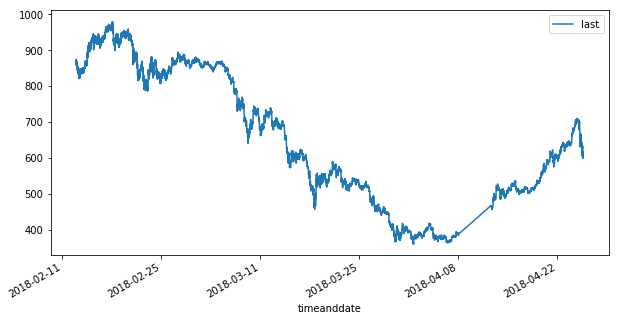

In [6]:
tickerdf.plot(x='timeanddate', y='last', figsize=(10,5))

Now to look at tweets - first put them all in a new pandas dataframe

In [7]:
tweetdf = pd.DataFrame(list(db.tweets.find({}, {'timeanddate': 1, 'polarity': 1, 'subjectivity': 1})))
tweetdf['timeanddate'] = pd.to_datetime(tweetdf['timeanddate'])
tweetdf['subjectivity'] = pd.to_numeric(tweetdf['subjectivity'])
tweetdf['polarity'] = pd.to_numeric(tweetdf['polarity'])

MemoryError: 

Take the datetimes from the start of the information and then create a couple of variables so we can search between 10 minute intervals

In [ ]:
#c = parse(tweetdf['timeanddate'].iloc[0]) # get first datetime and then turn the str(datetime) into datetime value
c = tweetdf['timeanddate'].iloc[0]
b = datetime.timedelta(minutes=10) # timedelta of 10 minutes
a = c - b # This is the start 
print(c)
print(type(c))
a += 2*b
print(a)
print(type(a))

Define a function to iterate through the mongodb and get the average of field x

In [ ]:
# might be able to use this below to chose the range of stuff
timeframe = tickerdf[(tickerdf['timeanddate'] > c) & (tickerdf['timeanddate'] <= a)]
print(timeframe)

In [ ]:
# print off the polarity/subjectivity means or medians of something

#print(timeframe['polarity'].mean())
#print(timeframe['subjectivity'].mean())
#print(timeframe['polarity'].median())
#print(timeframe['subjectivity'].median())

Make a new dataframe with more exciting information including means, medians etc: 

In [ ]:
# create a bunch of lists that will become dataframe series
times = []
polaritymeans = []
subjectivitymeans = []
polaritymedians = []
subjectivitymedians = []
polaritymeanindices = []
polaritymedianindices = []


# then make them dataframe series
for index, row in tickerdf.iterrows():
    c = row['timeanddate']
    b = datetime.timedelta(minutes=10) # timedelta of 10 minutes
    a = c - b # This is the start 
    timeframe = tweetdf[(tweetdf['timeanddate'] > a) & (tweetdf['timeanddate'] <= c)]
    times.append(row['timeanddate'])
    polaritymeans.append(timeframe['polarity'].mean())
    subjectivitymeans.append(timeframe['subjectivity'].mean())
    polaritymedians.append(timeframe['polarity'].median())
    subjectivitymedians.append(timeframe['subjectivity'].median())
    
    # Also do the calculations for indices if you want to make them on this loop
    polaritymeanindices.append(timeframe['polarity'].mean() * timeframe['subjectivity'].mean())
    polaritymedianindices.append(timeframe['polarity'].median() * timeframe['subjectivity'].median())

In [ ]:
# now you've got a list of stuff from iterating through - put them into a dataframe
newdf = pd.DataFrame({'timeanddate': times,
                     'polaritymeans': polaritymeans,
                     'subjectivitymeans': subjectivitymeans,
                     'polaritymedians': polaritymedians,
                     'subjectivitymedians': subjectivitymedians,
                     'polaritymeanindices': polaritymeanindices,
                     'polaritymedianindices': polaritymedianindices})

# This next bit it just printing out a chart of 3 variables

# Variables being:
x = newdf['timeanddate']
y1 = newdf['polaritymeanindices']
y2 = tickerdf['last']
y3 = newdf['polaritymedianindices']

# Plot variables
fig, ax1 = plt.subplots(figsize=(10,5))

ax2 = ax1.twinx()
ax1.plot(x, y1, 'r-')
ax1.plot(x, y3, 'g-')
ax2.plot(x, y2, 'b-')

ax1.set_xlabel('timeanddate')
ax1.set_ylabel('indices', color = 'r')
ax2.set_ylabel('price', color = 'b')
ax1.set_ylim([-0.1,0.4])
# ax1.set_xlim([xmin,xmax])


plt.show()

In [ ]:
def correlation_matrix(df):
    from matplotlib import pyplot as plt
    from matplotlib import cm as cm

    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    cmap = cm.get_cmap('jet', 30)
    cax = ax1.imshow(df.corr(), interpolation="nearest", cmap=cmap)
    ax1.grid(True)
    plt.title('Abalone Feature Correlation')
    labels=['Sex','Length','Diam','Height','Whole','Shucked','Viscera','Shell','Rings',]
    ax1.set_xticklabels(labels,fontsize=6)
    ax1.set_yticklabels(labels,fontsize=6)
    # Add colorbar, make sure to specify tick locations to match desired ticklabels
    fig.colorbar(cax, ticks=[.75,.8,.85,.90,.95,1])
    plt.show()

correlation_matrix()